# Spectral Clustering for Image Segmentation

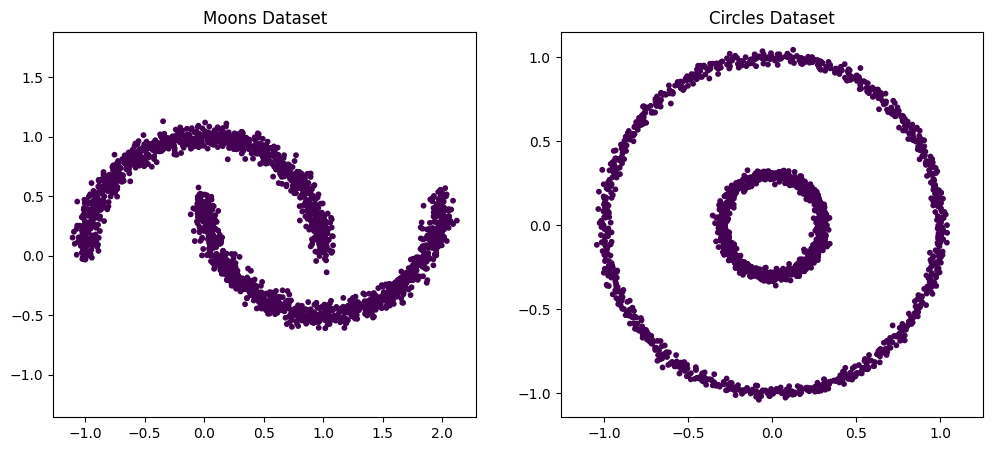

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles, make_blobs
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import kneighbors_graph
from scipy import sparse
from scipy.sparse.linalg import eigsh
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.preprocessing import StandardScaler

n_samples = 2000
random_state = 42


X_moons, y_moons = make_moons(n_samples=n_samples, noise=0.05, random_state=random_state)
X_circles, y_circles = make_circles(n_samples=n_samples, factor=0.3, noise=0.02, random_state=random_state)

def plot_clusters(X, labels, title):
    plt.scatter(X[:, 0], X[:, 1], c=labels, s=10, cmap='viridis')
    plt.title(title)
    plt.axis('equal')

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1); plot_clusters(X_moons, np.zeros(n_samples), "Moons Dataset")
plt.subplot(1, 2, 2); plot_clusters(X_circles, np.zeros(n_samples), "Circles Dataset")
plt.show()

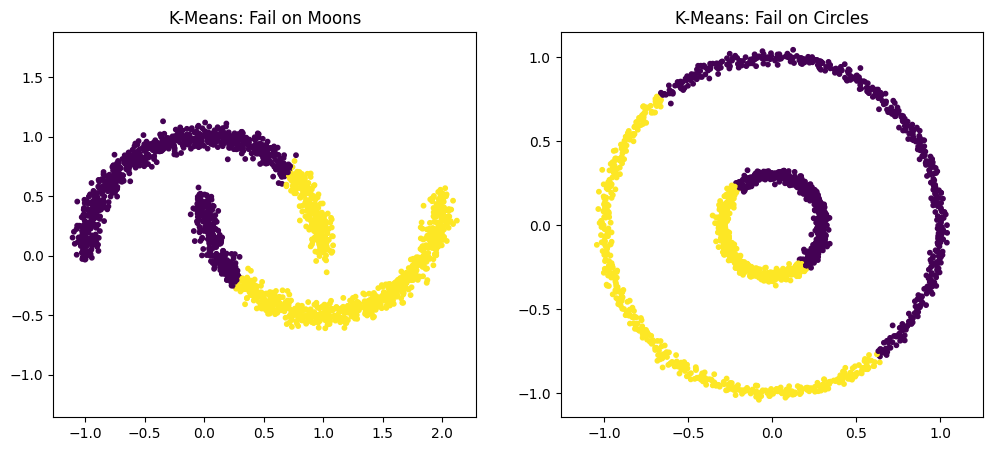

In [3]:
kmeans_moons = KMeans(n_clusters=2, random_state=random_state).fit(X_moons)
kmeans_circles = KMeans(n_clusters=2, random_state=random_state).fit(X_circles)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_clusters(X_moons, kmeans_moons.labels_, "K-Means: Fail on Moons")
plt.subplot(1, 2, 2)
plot_clusters(X_circles, kmeans_circles.labels_, "K-Means: Fail on Circles")
plt.show()

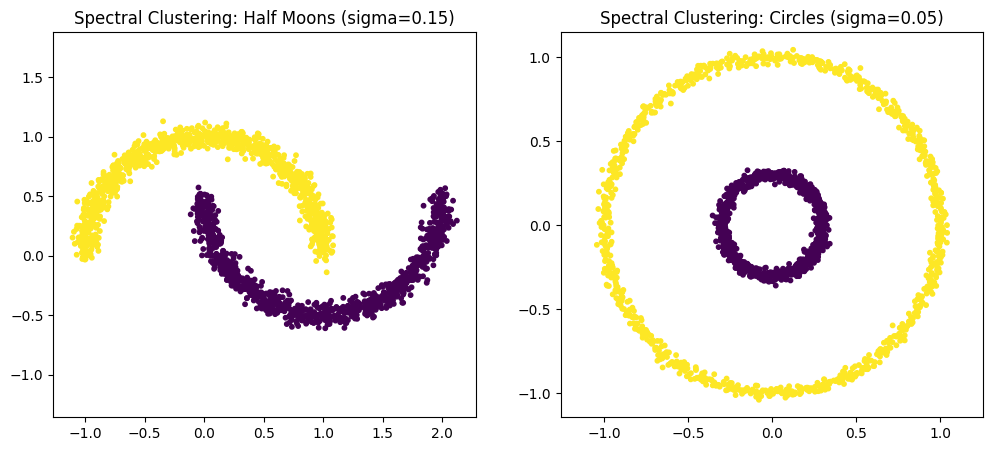

In [4]:
def spectral_clustering_dense(X, n_clusters, sigma=0.5):
    N = X.shape[0]
    
    dists = pairwise_distances(X, metric='euclidean')
    W = np.exp(- (dists ** 2) / (2 * sigma ** 2))
    np.fill_diagonal(W, 0) # Rimuoviamo self-loops
    
    d = np.sum(W, axis=1)
    d_inv_sqrt = np.power(d, -0.5)
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0
    D_inv_sqrt = np.diag(d_inv_sqrt)
    
    I = np.eye(N)
    L_sym = I - D_inv_sqrt @ W @ D_inv_sqrt

    eigenvals, eigenvecs = np.linalg.eigh(L_sym)
    U = eigenvecs[:, :n_clusters]
    
    rows_norm = np.linalg.norm(U, axis=1, keepdims=True)
    rows_norm[rows_norm == 0] = 1 
    U_normalized = U / rows_norm
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(U_normalized)
    
    return labels


labels_sc_moons = spectral_clustering_dense(X_moons, n_clusters=2, sigma=0.15)
labels_sc_circles = spectral_clustering_dense(X_circles, n_clusters=2, sigma=0.05)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plot_clusters(X_moons, labels_sc_moons, "Spectral Clustering: Half Moons (sigma=0.15)")

plt.subplot(1, 2, 2)
plot_clusters(X_circles, labels_sc_circles, "Spectral Clustering: Circles (sigma=0.05)")

plt.show()

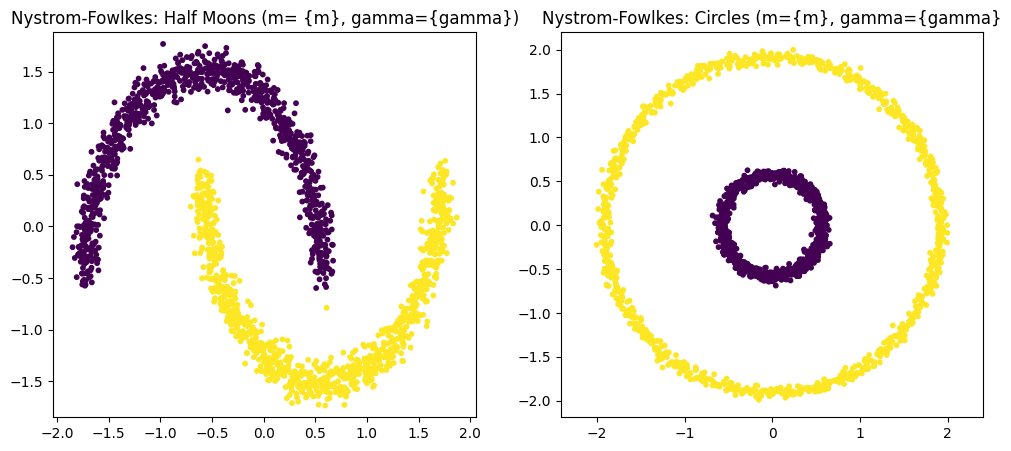

In [36]:
def nystrom_fowlkes_spectra_clustering(X, m, n_clusters, gamma=None):
    n = X.shape[0]
    if gamma is None:
        gamma = 1.0 / (2 * np.median(np.var(X, axis=0)))

    
    indices = np.random.choice(n, m, replace=False)
    mask = np.zeros(n, dtype=bool)
    mask[indices] = True
    
    X_sampled = X[mask]
    X_remaining = X[~mask]
    
    
    A = rbf_kernel(X_sampled, X_sampled, gamma=gamma)
    B = rbf_kernel(X_remaining, X_sampled, gamma=gamma)

#-------ROBA CHE DEVO CANCORA CAPIRE BENE--------
    # 3. NORMALIZZAZIONE LAPLACIANA (Il pezzo mancante)
    # Calcolo del grado d (somma delle righe della matrice di affinità completa)
    d = np.concatenate([
        np.sum(A, axis=1) + np.sum(B.T, axis=1),
        np.sum(B, axis=1) + B @ (np.linalg.pinv(A) @ np.sum(B.T, axis=1))
    ])
    d_inv_sqrt = 1.0 / np.sqrt(d + 1e-10)
    
    # Normalizziamo A e B per riflettere la Laplaciana: K_norm = D^-1/2 K D^-1/2
    # Estraiamo i pezzi di D^-1/2
    d_m = d_inv_sqrt[:m]
    d_nm = d_inv_sqrt[m:]
    
    A_norm = np.diag(d_m) @ A @ np.diag(d_m)
    B_norm = np.diag(d_nm) @ B @ np.diag(d_m)

#FINO A QUI---------------------------------

    # 4. Decomposizione di A_norm A = U V U'
    v_eigenvals, U = np.linalg.eigh(A_norm)
    v_eigenvals = np.maximum(v_eigenvals[::-1], 1e-10)
    U = U[:, ::-1]

    # A^(-1/2)
    A_inv_sqrt = U @ np.diag(1.0 / np.sqrt(v_eigenvals)) @ U.T

    # 5. Decomposizione Q ; Q = A_norm + A^(-1/2) B_norm' B_norm A^(-1/2)
    Q = A_norm + A_inv_sqrt @ (B_norm.T @ B_norm) @ A_inv_sqrt
    v_q, U_q = np.linalg.eigh(Q)
    v_q = np.maximum(v_q[::-1], 1e-10)
    U_q = U_q[:, ::-1]

    
    combined_AB_norm = np.zeros((n, m))
    combined_AB_norm[mask] = A_norm
    combined_AB_norm[~mask] = B_norm
    
    V_final = combined_AB_norm @ A_inv_sqrt @ U_q @ np.diag(1.0 / np.sqrt(v_q))

    
    V_k = V_final[:, :n_clusters] 
    
    
    row_norms = np.linalg.norm(V_k, axis=1, keepdims=True)
    V_normalized = V_k / (row_norms + 1e-10)

    return KMeans(n_clusters=n_clusters, n_init=10).fit_predict(V_normalized)

scaler = StandardScaler()
X_moons_scaled = scaler.fit_transform(X_moons)
X_circles_scaled = scaler.fit_transform(X_circles)

labels_nystrom_moons = nystrom_fowlkes_spectra_clustering(X_moons_scaled, m=150, n_clusters=2, gamma=10.0)
labels_nystrom_circles = nystrom_fowlkes_spectra_clustering(X_circles_scaled, m=150, n_clusters=2, gamma=2.0)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_clusters(X_moons_scaled, labels_nystrom_moons, "Nystrom-Fowlkes: Half Moons (m= {m}, gamma={gamma})")
plt.subplot(1, 2, 2)
plot_clusters(X_circles_scaled, labels_nystrom_circles, "Nystrom-Fowlkes: Circles (m={m}, gamma={gamma}")

In [6]:
#CELLA VELOCE PER VEDERE TEMPO E PRECISIONE

import time
from sklearn.cluster import SpectralClustering
from sklearn.metrics import adjusted_rand_score

# Parametri
m_points = 150
gamma_test = 2.0

print(f"Esecuzione test su {X_circles_scaled.shape[0]} punti...")

# --- 1. Test Nyström-Fowlkes ---
start = time.time()
labels_nyst = nystrom_fowlkes_spectra_clustering(X_circles_scaled, m=m_points, n_clusters=2, gamma=gamma_test)
time_nyst = time.time() - start
ari_nyst = adjusted_rand_score(y_circles, labels_nyst)

# --- 2. Test Spectral Clustering Standard ---
start = time.time()
sc = SpectralClustering(n_clusters=2, gamma=gamma_test, affinity='rbf', eigen_solver='arpack')
labels_std = sc.fit_predict(X_circles_scaled)
time_std = time.time() - start
ari_std = adjusted_rand_score(y_circles, labels_std)

# --- Print Risultati ---
print("-" * 40)
print(f"{'METODO':<20} | {'TEMPO':<10} | {'PRECISIONE (ARI)':<15}")
print("-" * 40)
print(f"{'Nyström-Fowlkes':<20} | {time_nyst:.4f}s | {ari_nyst:.4f}")
print(f"{'Standard Spectral':<20} | {time_std:.4f}s | {ari_std:.4f}")
print("-" * 40)
print(f"🚀 Speedup: {time_std / time_nyst:.2f}x più veloce")
print(f"📊 Delta Precisione: {abs(ari_std - ari_nyst):.4f}")

Esecuzione test su 2000 punti...
----------------------------------------
METODO               | TEMPO      | PRECISIONE (ARI)
----------------------------------------
Nyström-Fowlkes      | 0.0701s | 1.0000
Standard Spectral    | 0.5823s | 1.0000
----------------------------------------
🚀 Speedup: 8.30x più veloce
📊 Delta Precisione: 0.0000


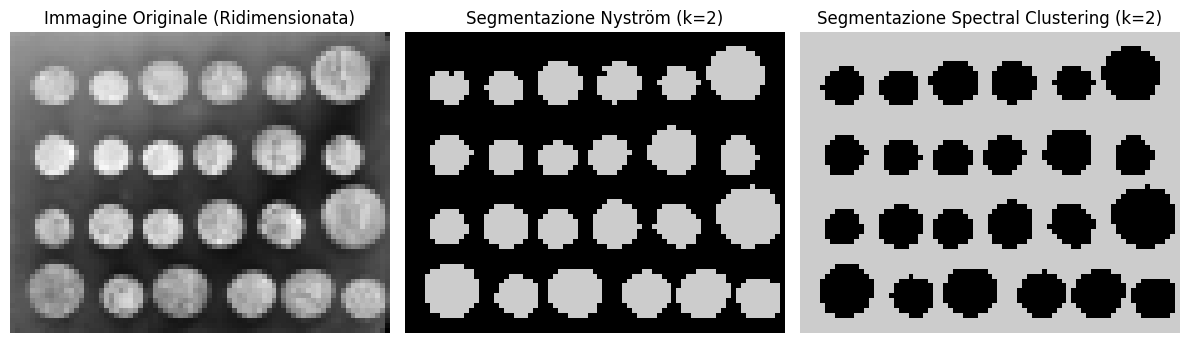

In [7]:
#proviamo  con  immagine monete: qualità simile: confronto tra tempi importate!!!

import matplotlib.pyplot as plt
from skimage import data, color
from skimage.transform import rescale
import numpy as np
import time

# 1. Caricamento e ridimensionamento (fondamentale per non saturare la RAM)
image = data.coins()
image_rescaled = rescale(image, 0.2, anti_aliasing=True) # Ridimensiona al 20%
rows, cols = image_rescaled.shape

# 2. Prepariamo i dati: usiamo posizione (r,c) e intensità del grigio
# Creiamo una matrice di feature (n_pixel x 3)
r_coords, c_coords = np.indices((rows, cols))
X_img = np.column_stack([
    r_coords.ravel(), 
    c_coords.ravel(), 
    image_rescaled.ravel() * 100  # Pesiamo l'intensità per darle importanza
])

# Scaliamo i dati per il clustering
X_img_scaled = StandardScaler().fit_transform(X_img)

# 3. Eseguiamo il tuo algoritmo Nyström-Fowlkes
# Proviamo con 2 cluster (monete vs sfondo) o più (per catturare ombre diverse)
n_cl = 2
labels = nystrom_fowlkes_spectra_clustering(X_img_scaled, m=200, n_clusters=n_cl, gamma=5.0)
labels2= spectral_clustering_dense(X_img_scaled, n_clusters=n_cl, sigma=0.5)
# 4. Ricostruiamo l'immagine dalle labels
segmentation = labels.reshape((rows, cols))
segmentation2= labels2.reshape((rows, cols))
# 5. Visualizzazione
fig, ax = plt.subplots(1, 3, figsize=(12, 6))

ax[0].imshow(image_rescaled, cmap='gray')
ax[0].set_title("Immagine Originale (Ridimensionata)")
ax[0].axis('off')

ax[1].imshow(segmentation, cmap='nipy_spectral')
ax[1].set_title(f"Segmentazione Nyström (k={n_cl})")
ax[1].axis('off')

ax[2].imshow(segmentation2, cmap='nipy_spectral')
ax[2].set_title(f"Segmentazione Spectral Clustering (k={n_cl})")
ax[2].axis('off')

plt.tight_layout()
plt.show()



Test Astronauta: 23716 pixel e 5 Feature (x, y, R, G, B)


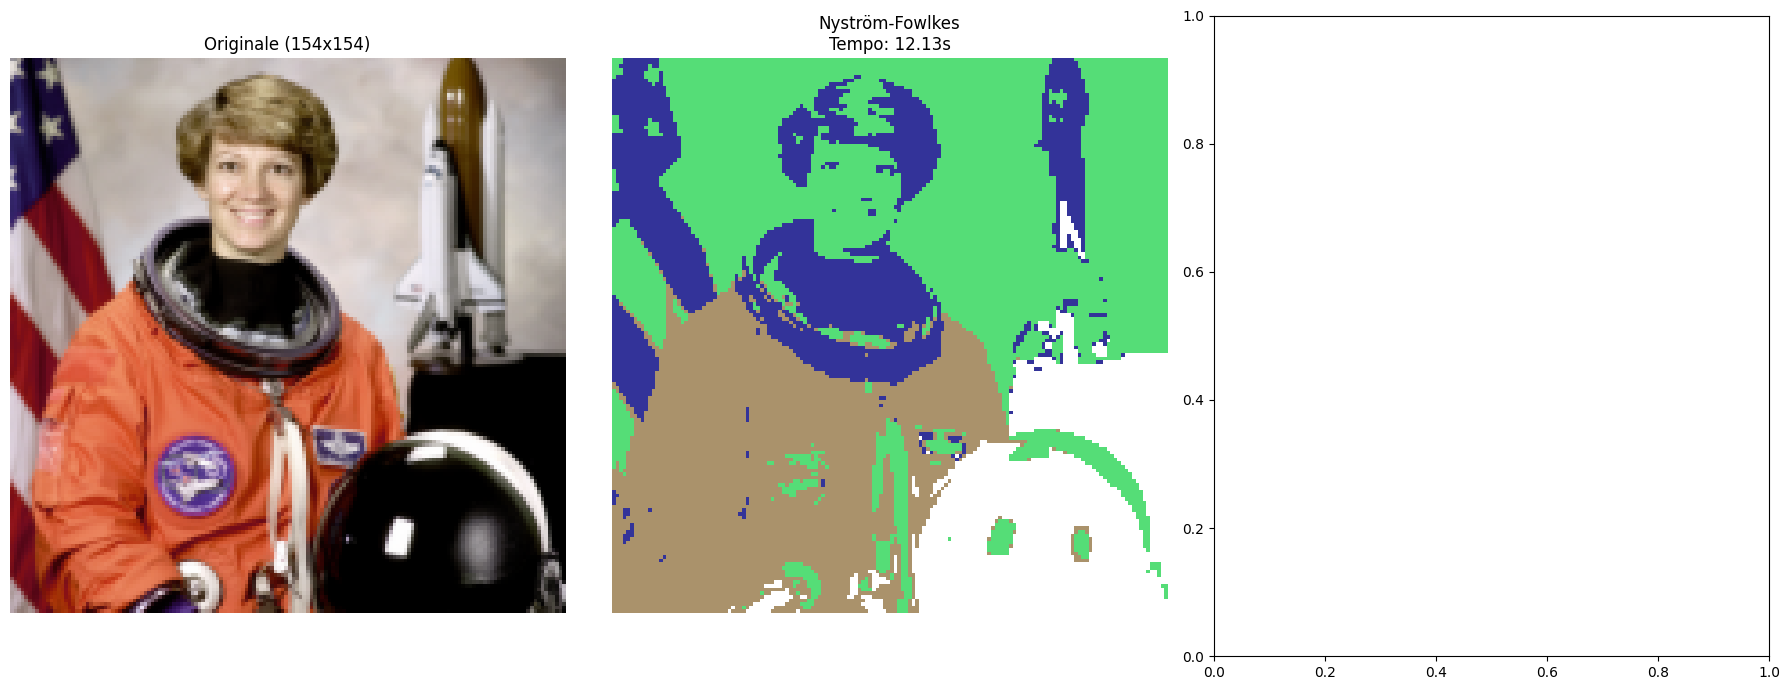

In [37]:
from skimage import data
from sklearn.preprocessing import StandardScaler
import time

# 1. Carichiamo l'astronauta (immagine a colori)
img_astro = data.astronaut()

# Definiamo una scala che renda l'immagine "proibitiva" per il Dense
# Con 0.15 abbiamo circa 11.500 pixel. 
# Per il Dense significa una matrice 11.500 x 11.500 (circa 1GB solo di RAM)
scale_factor = 0.30
img_res = rescale(img_astro, scale_factor, channel_axis=-1, anti_aliasing=True)
rows, cols, dims = img_res.shape
n_pixels = rows * cols

# 2. Creazione Feature Vector (x, y, R, G, B)
r_coords, c_coords = np.indices((rows, cols))
X_astro = np.column_stack([
    r_coords.ravel() * 1.5, 
    c_coords.ravel() * 1.5, 
    img_res[:,:,0].ravel() * 150, # Canale R
    img_res[:,:,1].ravel() * 150, # Canale G
    img_res[:,:,2].ravel() * 1500  # Canale B
])

X_scaled = StandardScaler().fit_transform(X_astro)

print(f"Test Astronauta: {n_pixels} pixel e 5 Feature (x, y, R, G, B)")

# 3. Esecuzione Nyström-Fowlkes
# Usiamo n_clusters=4 per provare a separare: tuta, viso, sfondo scuro, bandiera/dettagli
start_nyst = time.time()
labels_nyst = nystrom_fowlkes_spectra_clustering(X_scaled, m=500, n_clusters=4, gamma=1.3)
time_nyst = time.time() - start_nyst

# 4. Esecuzione Spectral Dense (Tuo)
'''print("Calcolo Dense in corso... (prepara la pazienza)")
start_dense = time.time()
try:
    labels_dense = spectral_clustering_dense(X_scaled, n_clusters=4, sigma=0.8)
    time_dense = time.time() - start_dense
except MemoryError:
    labels_dense = None
    print("❌ Il metodo Dense è crashato!")'''

# 5. Visualizzazione
fig, ax = plt.subplots(1, 3, figsize=(18, 7))

ax[0].imshow(img_res)
ax[0].set_title(f"Originale ({rows}x{cols})")
ax[0].axis('off')

ax[1].imshow(labels_nyst.reshape(rows, cols), cmap='terrain')
ax[1].set_title(f"Nyström-Fowlkes\nTempo: {time_nyst:.2f}s")
ax[1].axis('off')

'''if labels_dense is not None:
    ax[2].imshow(labels_dense.reshape(rows, cols), cmap='terrain')
    ax[2].set_title(f"Dense (Tuo)\nTempo: {time_dense:.2f}s")
else:
    ax[2].text(0.5, 0.5, "MEMORY ERROR", ha='center', va='center', color='red', fontsize=15)
    ax[2].set_title("Dense (Tuo)")
ax[2].axis('off')'''

plt.tight_layout()
plt.show()

Dataset: Astronauta | Pixel: 23716 | Dimensioni: 154x154
Elaborazione Gamma=0.3...
Elaborazione Gamma=1.3...
Elaborazione Gamma=5.0...
Elaborazione Gamma=8.0...
Elaborazione Gamma=10.0...
Elaborazione Gamma=15.0...


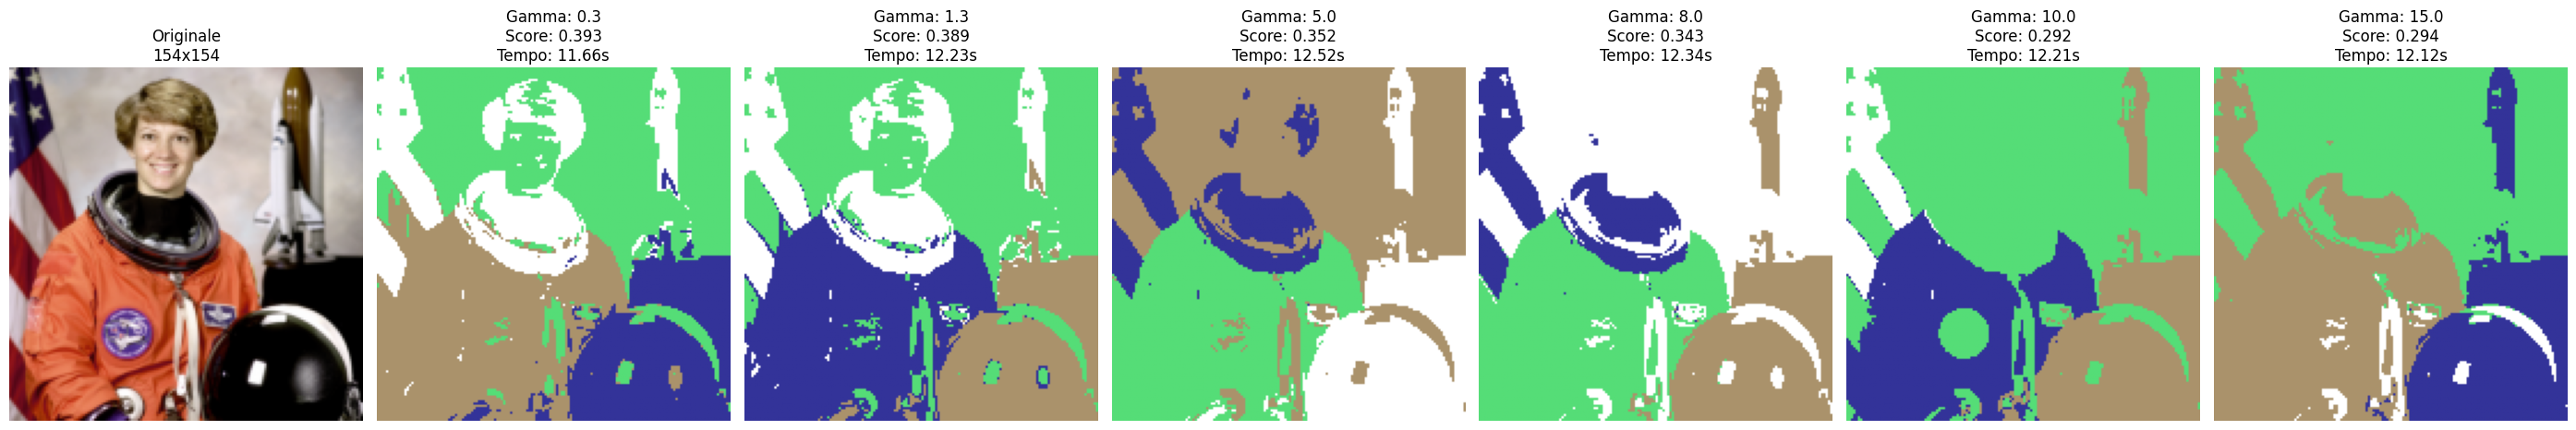

--------------------------------------------------
Analisi completata.
Il Gamma che offre la migliore separazione è 0.3 con uno score di 0.3926.


In [38]:
###CON ANALISI DEL MIGLIORE GAMMA USANDO LA SILHOUETTE SCORE ---TROVATO CHE IL MIGLIROE E' 1.3 

import numpy as np
import matplotlib.pyplot as plt
import time
from skimage import data
from skimage.transform import rescale
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# --- 1. PREPARAZIONE DATASET (ASTRONAUT) ---
img_astro = data.astronaut()

# Scala al 30% per avere circa 45.000-50.000 pixel
scale_factor = 0.30
img_res = rescale(img_astro, scale_factor, channel_axis=-1, anti_aliasing=True)
rows, cols, dims = img_res.shape
n_pixels = rows * cols

# Creazione Feature Vector: Posizione (x,y) + Colore (R,G,B)
r_coords, c_coords = np.indices((rows, cols))
X_astro = np.column_stack([
    r_coords.ravel(), 
    c_coords.ravel(), 
    img_res[:,:,0].ravel() * 300, # Peso per il canale Rosso
    img_res[:,:,1].ravel() * 300, # Peso per il canale Verde
    img_res[:,:,2].ravel() * 300  # Peso per il canale Blu
])

# Normalizzazione fondamentale per lo Spectral Clustering
X_scaled = StandardScaler().fit_transform(X_astro)

print(f"Dataset: Astronauta | Pixel: {n_pixels} | Dimensioni: {rows}x{cols}")

# --- 2. ANALISI DEI PARAMETRI GAMMA ---
gamma_values = [0.3, 1.3, 5.0, 8.0, 10.0, 15.0]
results = []

for g in gamma_values:
    print(f"Elaborazione Gamma={g}...")
    t_start = time.time()
    
    # Eseguiamo Nyström-Fowlkes (m=300 è circa lo 0.6% dei dati)
    labels = nystrom_fowlkes_spectra_clustering(X_scaled, m=500, n_clusters=4, gamma=g)
    
    t_end = time.time() - t_start
    
    # Calcolo Silhouette Score su un campione di 1000 pixel per velocità
    sample_idx = np.random.choice(n_pixels, 1000, replace=False)
    score = silhouette_score(X_scaled[sample_idx], labels[sample_idx])
    
    results.append({
        'gamma': g,
        'labels': labels,
        'time': t_end,
        'score': score
    })

# --- 3. VISUALIZZAZIONE RISULTATI ---
n_plots = len(gamma_values) + 1
fig, axes = plt.subplots(1, n_plots, figsize=(4 * n_plots, 5))

# Plot Immagine Originale
axes[0].imshow(img_res)
axes[0].set_title(f"Originale\n{rows}x{cols}")
axes[0].axis('off')

# Plot dei vari Gamma
for i, res in enumerate(results):
    seg_map = res['labels'].reshape(rows, cols)
    axes[i+1].imshow(seg_map, cmap='terrain')
    title = (f"Gamma: {res['gamma']}\n"
             f"Score: {res['score']:.3f}\n"
             f"Tempo: {res['time']:.2f}s")
    axes[i+1].set_title(title)
    axes[i+1].axis('off')

plt.tight_layout()
plt.show()

# --- 4. CONCLUSIONI ---
best_res = max(results, key=lambda x: x['score'])
print("-" * 50)
print(f"Analisi completata.")
print(f"Il Gamma che offre la migliore separazione è {best_res['gamma']} "
      f"con uno score di {best_res['score']:.4f}.")

Test su 32041 pixel. Matrice Dense occuperebbe circa 8 GB.
⚠️ Saltiamo il metodo Dense: 32041 pixel richiederebbero più di 2 minuti e troppa RAM.
In un'analisi reale, questo è il punto in cui lo Spectral Clustering standard fallisce.

--- Tentativo Spectral Clustering Dense ---

--- Esecuzione Nyström-Fowlkes (Versione Finale) ---
✅ Nyström completato con successo in 21.57s


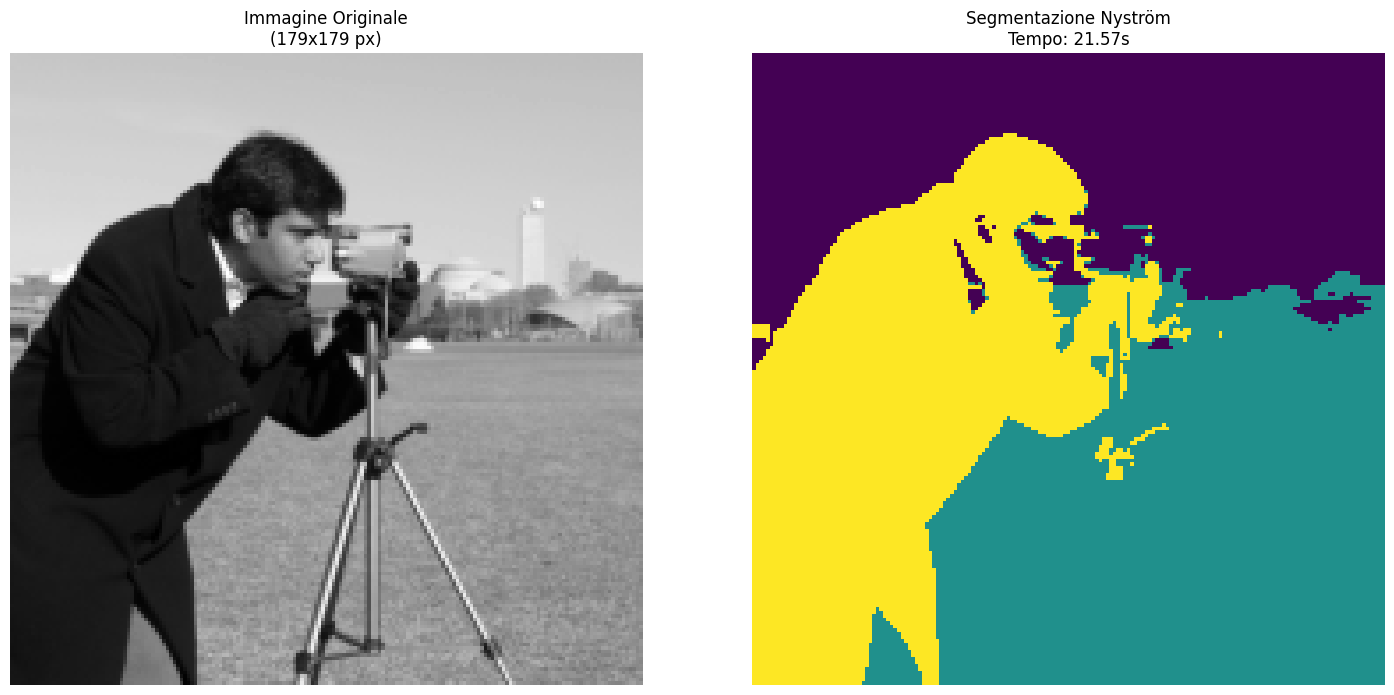

In [39]:
##PROVIAMO CON IMMAGINE DEL FOTOGRAFO PER VEDERE SE PTTENGO RISULTATO MEZZO DECENTE CON NYMSTROM
import numpy as np
import matplotlib.pyplot as plt
import time
from skimage import data
from skimage.transform import rescale
from sklearn.preprocessing import StandardScaler

# --- 1. CARICAMENTO E SCALING "SFIDANTE" ---
img = data.camera()

# Usiamo una scala di 0.35 -> circa 32.000 pixel
# Per il Dense, questo significa una matrice di affinità di ~8GB di RAM!
scale_factor = 0.35 
img_res = rescale(img, scale_factor, anti_aliasing=True)
rows, cols = img_res.shape
n_pixels = rows * cols

# Feature: Posizione (x, y) + Intensità di grigio
r_coords, c_coords = np.indices((rows, cols))
X_cam = np.column_stack([
    r_coords.ravel() * 150 , 
    c_coords.ravel() * 150,
    img_res.ravel() * 300
])
X_scaled = StandardScaler().fit_transform(X_cam)

print(f"Test su {n_pixels} pixel. Matrice Dense occuperebbe circa 8 GB.")
limit_pixel = 20000
if n_pixels > limit_pixel:
    print(f"⚠️ Saltiamo il metodo Dense: {n_pixels} pixel richiederebbero più di 2 minuti e troppa RAM.")
    print("In un'analisi reale, questo è il punto in cui lo Spectral Clustering standard fallisce.")
else:
    start_d = time.time()
    labels_dense = spectral_clustering_dense(X_scaled, n_clusters=3, sigma=0.5)
    print(f"Dense completato in {time.time()-start_d:.2f}s")

# --- 2. TENTATIVO SPECTRAL DENSE ---
print("\n--- Tentativo Spectral Clustering Dense ---")
'''try:
    start_d = time.time()
    # Limitiamo il tempo o la memoria idealmente, ma qui probabilmente darà MemoryError
    labels_dense = spectral_clustering_dense(X_scaled, n_clusters=3, sigma=0.5)
    print(f"Dense completato in {time.time()-start_d:.2f}s")
except MemoryError:
    labels_dense = None
    print("❌ ERRORE: Memoria insufficiente per il metodo Dense!")
except Exception as e:
    labels_dense = None
    print(f"❌ Errore durante l'esecuzione del metodo Dense: {e}")'''

# --- 3. ESECUZIONE NYSTRÖM-FOWLKES ---
print("\n--- Esecuzione Nyström-Fowlkes (Versione Finale) ---")
start_n = time.time()
# Usiamo m=500 per una qualità decente
labels_nyst = nystrom_fowlkes_spectra_clustering(X_scaled, m=500, n_clusters=3, gamma=6.0)
time_nyst = time.time() - start_n
print(f"✅ Nyström completato con successo in {time_nyst:.2f}s")

# --- 4. VISUALIZZAZIONE ---
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

ax[0].imshow(img_res, cmap='gray')
ax[0].set_title(f"Immagine Originale\n({rows}x{cols} px)")
ax[0].axis('off')

ax[1].imshow(labels_nyst_final.reshape(rows, cols), cmap='viridis')
ax[1].set_title(f"Segmentazione Nyström\nTempo: {time_nyst:.2f}s")
ax[1].axis('off')



plt.tight_layout()
plt.show()


In [ ]:
###analaisi gamma con silhouette score per immagine fotografo

import numpy as np
import matplotlib.pyplot as plt
import time
from skimage import data
from skimage.transform import rescale
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# --- 1. PREPARAZIONE DATASET ---
img = data.camera()
scale_factor = 0.40  # Risoluzione media per un test significativo
img_res = rescale(img, scale_factor, anti_aliasing=True)
rows, cols = img_res.shape
n_pixels = rows * cols

r_coords, c_coords = np.indices((rows, cols))
X_cam = np.column_stack([
    r_coords.ravel() * 1.5, 
    c_coords.ravel() * 1.5, 
    img_res.ravel() * 100
])
X_scaled = StandardScaler().fit_transform(X_cam)

print(f"Analisi su {n_pixels} pixel.")

# --- 2. RICERCA DEL MIGLIOR GAMMA CON SILHOUETTE ---
gamma_candidates =  [6.0, 6.2, 6.5, 6.7, 6.9]
gamma_results = []

print("\nAvvio analisi Silhouette per trovare il miglior Gamma...")

for g in gamma_candidates:
    # Usiamo m=300 per i test veloci di gamma
    labels_tmp = nystrom_fowlkes_spectra_clustering(X_scaled, m=300, n_clusters=3, gamma=g)
    
    # Sottocampionamento per calcolare la Silhouette velocemente
    sample_size = min(1000, n_pixels)
    idx = np.random.choice(n_pixels, sample_size, replace=False)
    
    score = silhouette_score(X_scaled[idx], labels_tmp[idx])
    gamma_results.append((g, score, labels_tmp))
    print(f"Gamma {g:4.1f} | Silhouette Score: {score:.4f}")

# Troviamo il vincitore
best_gamma, best_score, _ = max(gamma_results, key=lambda x: x[1])
print(f"\n✅ Miglior Gamma trovato: {best_gamma} (Score: {best_score:.4f})")

# --- 3. ESECUZIONE FINALE CON MIGLIOR GAMMA ---
# Usiamo m=500 per la qualità definitiva
print(f"\nEsecuzione finale Nyström con Gamma={best_gamma} e m=500...")
labels_final = nystrom_fowlkes_spectra_clustering(X_scaled, m=500, n_clusters=3, gamma=best_gamma)

# --- 4. VISUALIZZAZIONE ---
n_cols = len(gamma_candidates) + 1
fig, axes = plt.subplots(1, n_cols, figsize=(4 * n_cols, 5))

# Immagine originale
axes[0].imshow(img_res, cmap='gray')
axes[0].set_title("Originale")
axes[0].axis('off')

# Plot dei vari test di gamma
for i, (g, score, l_plot) in enumerate(gamma_results):
    axes[i+1].imshow(l_plot.reshape(rows, cols), cmap='viridis')
    axes[i+1].set_title(f"Gamma: {g}\nScore: {score:.3f}")
    axes[i+1].axis('off')

plt.tight_layout()
plt.show()

Analisi su 42025 pixel.

Avvio analisi Silhouette per trovare il miglior Gamma...
